# 使用Sequence to Sequence 模型，英翻中
### 程式修改自 [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/)

In [ ]:
# 載入相關套件
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

Download Tab-delimited Bilingual Sentence Pairs
https://www.manythings.org/anki/

In [ ]:
!wget https://www.manythings.org/anki/cmn-eng.zip
!unzip cmn-eng.zip

--2024-12-22 09:01:54--  https://www.manythings.org/anki/cmn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1293753 (1.2M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.23M  4.86MB/s    in 0.3s    

2024-12-22 09:01:54 (4.86 MB/s) - ‘cmn-eng.zip’ saved [1293753/1293753]

Archive:  cmn-eng.zip
  inflating: cmn.txt                 
  inflating: _about.txt              


In [ ]:
!pip install opencc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.7 MB/s eta 0:00:00


In [ ]:
from opencc import OpenCC

# 初始化 OpenCC，指定簡轉繁配置
cc = OpenCC('s2t')  # 's2t' 表示 Simplified to Traditional

# 定義檔案路徑
input_file = '/content/cmn.txt'  # 輸入的簡體中文檔案
output_file = '/content/tmn.txt'  # 輸出的繁體中文檔案

# 讀取檔案並進行簡轉繁
with open(input_file, 'r', encoding='utf-8') as f:
    content = f.read()

converted_content = cc.convert(content)

# 將轉換後的內容寫入新檔案
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(converted_content)

print(f"已將 {input_file} 簡體中文內容轉換為繁體，並儲存至 {output_file}")

已將 /content/cmn.txt 簡體中文內容轉換為繁體，並儲存至 /content/tmn.txt


## 參數設定

In [2]:
# 參數設定
batch_size = 64      # 訓練批量
epochs = 100         # 訓練執行週期
latent_dim = 256     # 隱藏層輸出維度
num_samples = 10000  # 訓練樣本數
# https://www.manythings.org/anki/
data_path = "/content/tmn.txt" # 訓練資料集檔案路徑

## 讀取訓練檔案，進行資料前置處理

In [ ]:
# 整理兩種語言的字彙表
input_texts = []  # 原始語言
target_texts = [] # 目標語言
input_characters = set()  # 原始語言字母列表
target_characters = set() # 目標語言字母列表

# 讀取cmn.txt檔案
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# 每列均以 tab 符號隔開，英文為input，中文為output
for line in lines[: min(num_samples, len(lines) - 1)]:
    arr = line.split("\t")
    input_text, target_text = arr[0], arr[1]

    # 目標語言前面加 "\t"，後前面加 "\n"
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

## 統計筆數、字母、長度

In [ ]:
# 統計筆數、字母、長度
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("原始語言筆數:", len(input_texts))
print("原始語言字母數:", num_encoder_tokens)
print("目標語言字母數:", num_decoder_tokens)
print("原始語言語句最大長度:", max_encoder_seq_length)
print("目標語言語句最大長度:", max_decoder_seq_length)

原始語言筆數: 10000
原始語言字母數: 73
目標語言字母數: 2039
原始語言語句最大長度: 25
目標語言語句最大長度: 22


In [ ]:
' '.join(input_characters)

'  ! " $ % \' , - . 0 1 2 3 4 5 6 7 8 9 : ? A B C D E F G H I J K L M N O P Q R S T U V W Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z ’'

In [ ]:
' '.join(target_characters)

'\t \n   ! " ( ) , . 0 1 2 3 4 5 6 7 8 9 : ? A B C D F J M O P T U a c e h i m o r s t w y “ ” 。 一 丁 七 丈 三 上 下 不 丐 世 丟 並 中 主 久 之 乎 乏 乘 九 乞 也 乳 乾 亂 了 事 二 互 五 井 些 亞 亡 交 享 京 亮 人 什 仁 仇 今 介 仍 仔 他 仗 付 代 令 以 仰 件 任 份 仿 企 伍 伏 休 伙 伯 估 伴 似 但 佈 位 低 住 佑 佔 何 佛 作 你 佩 佬 佳 使 來 例 供 依 侮 便 係 俄 保 信 修 俱 倆 個 倍 們 倒 倔 倖 候 借 倦 倫 值 假 偉 做 停 健 側 偵 偶 偷 傘 備 傢 傭 傲 傳 債 傷 傻 僅 像 僞 僱 價 儘 償 優 允 元 兄 充 兆 兇 先 光 克 免 兒 兔 入 內 全 兩 八 公 六 共 兵 其 具 典 冊 再 冒 冠 冬 冰 冷 准 凌 凍 凡 凳 出 刀 分 切 列 初 判 別 利 刪 刮 到 制 刷 刺 刻 則 削 前 剔 剛 剩 剪 創 劃 劇 力 功 加 助 努 劫 勇 動 務 勝 勞 勢 勵 勺 勿 包 匆 化 北 匙 匱 匹 區 十 千 升 午 卉 半 協 南 博 卡 印 危 即 厚 原 厭 厲 去 參 又 叉 及 友 反 叔 取 受 叛 叢 口 古 句 另 只 叫 可 史 右 司 吁 合 吉 同 名 吐 向 君 吝 吞 否 吧 含 吵 吸 吹 吻 吼 呀 呆 告 呢 周 味 呼 命 咋 和 咎 咒 咔 咖 咪 咬 咱 咳 品 哄 哈 員 哥 哦 哨 哩 哪 哭 哮 哺 唐 唔 售 唯 唱 唸 商 啊 問 啓 啜 啡 啤 啥 啦 喂 善 喉 喊 喔 喘 喜 喝 喪 喫 單 喱 喲 喻 嗇 嗎 嗓 嗝 嗨 嗽 嘆 嘔 嘗 嘛 嘲 嘴 嘿 噁 噓 噠 噢 器 噩 噪 噬 噴 嚇 嚏 嚐 嚥 嚨 嚮 嚴 嚼 囚 四 回 因 困 固 圈 國 圍 園 圓 圖 團 土 在 地 圾 址 坐 坡 坪 垃 型 埋 城 執 基 堂 堅 堆 堡 堪 報 場 塊 塔 塗 塞 填 增 墟 墨 壁 壓 壘 壞 壤 士 壯 壺 壽 夏 外 多 夜 夠 夢 夥 大 天 太 夫 失 夷 夾 奇 奉 奏 契 套 奮 女 奴 奶 她 好 如 妒 妙 妥 妳 妹 妻 姆 姊 始 姐 姑 委 姨

## 將字彙表轉為字典

In [ ]:
# 將字彙表轉為字典資料型態
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

## 利用字典將原文轉為數字

In [ ]:
# 利用字典將原文轉為數字
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder 輸出比輸入早一期
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## 建立模型

In [ ]:
# 建立模型
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 不使用 encoder 的輸出，只保留狀態(state)，即語意結構
encoder_states = [state_h, state_c]

# decoder 以 encoder 語意結構為輸入
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# 傳回 LSTM 每一個輸出
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 73)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, 2039)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        337,920 │ input_layer[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │      2,351,104 │ input_layer_1[0][0],   │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 2039)     │        524,023 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,213,047 (12.26 MB)

 Trainable params: 3,213,047 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

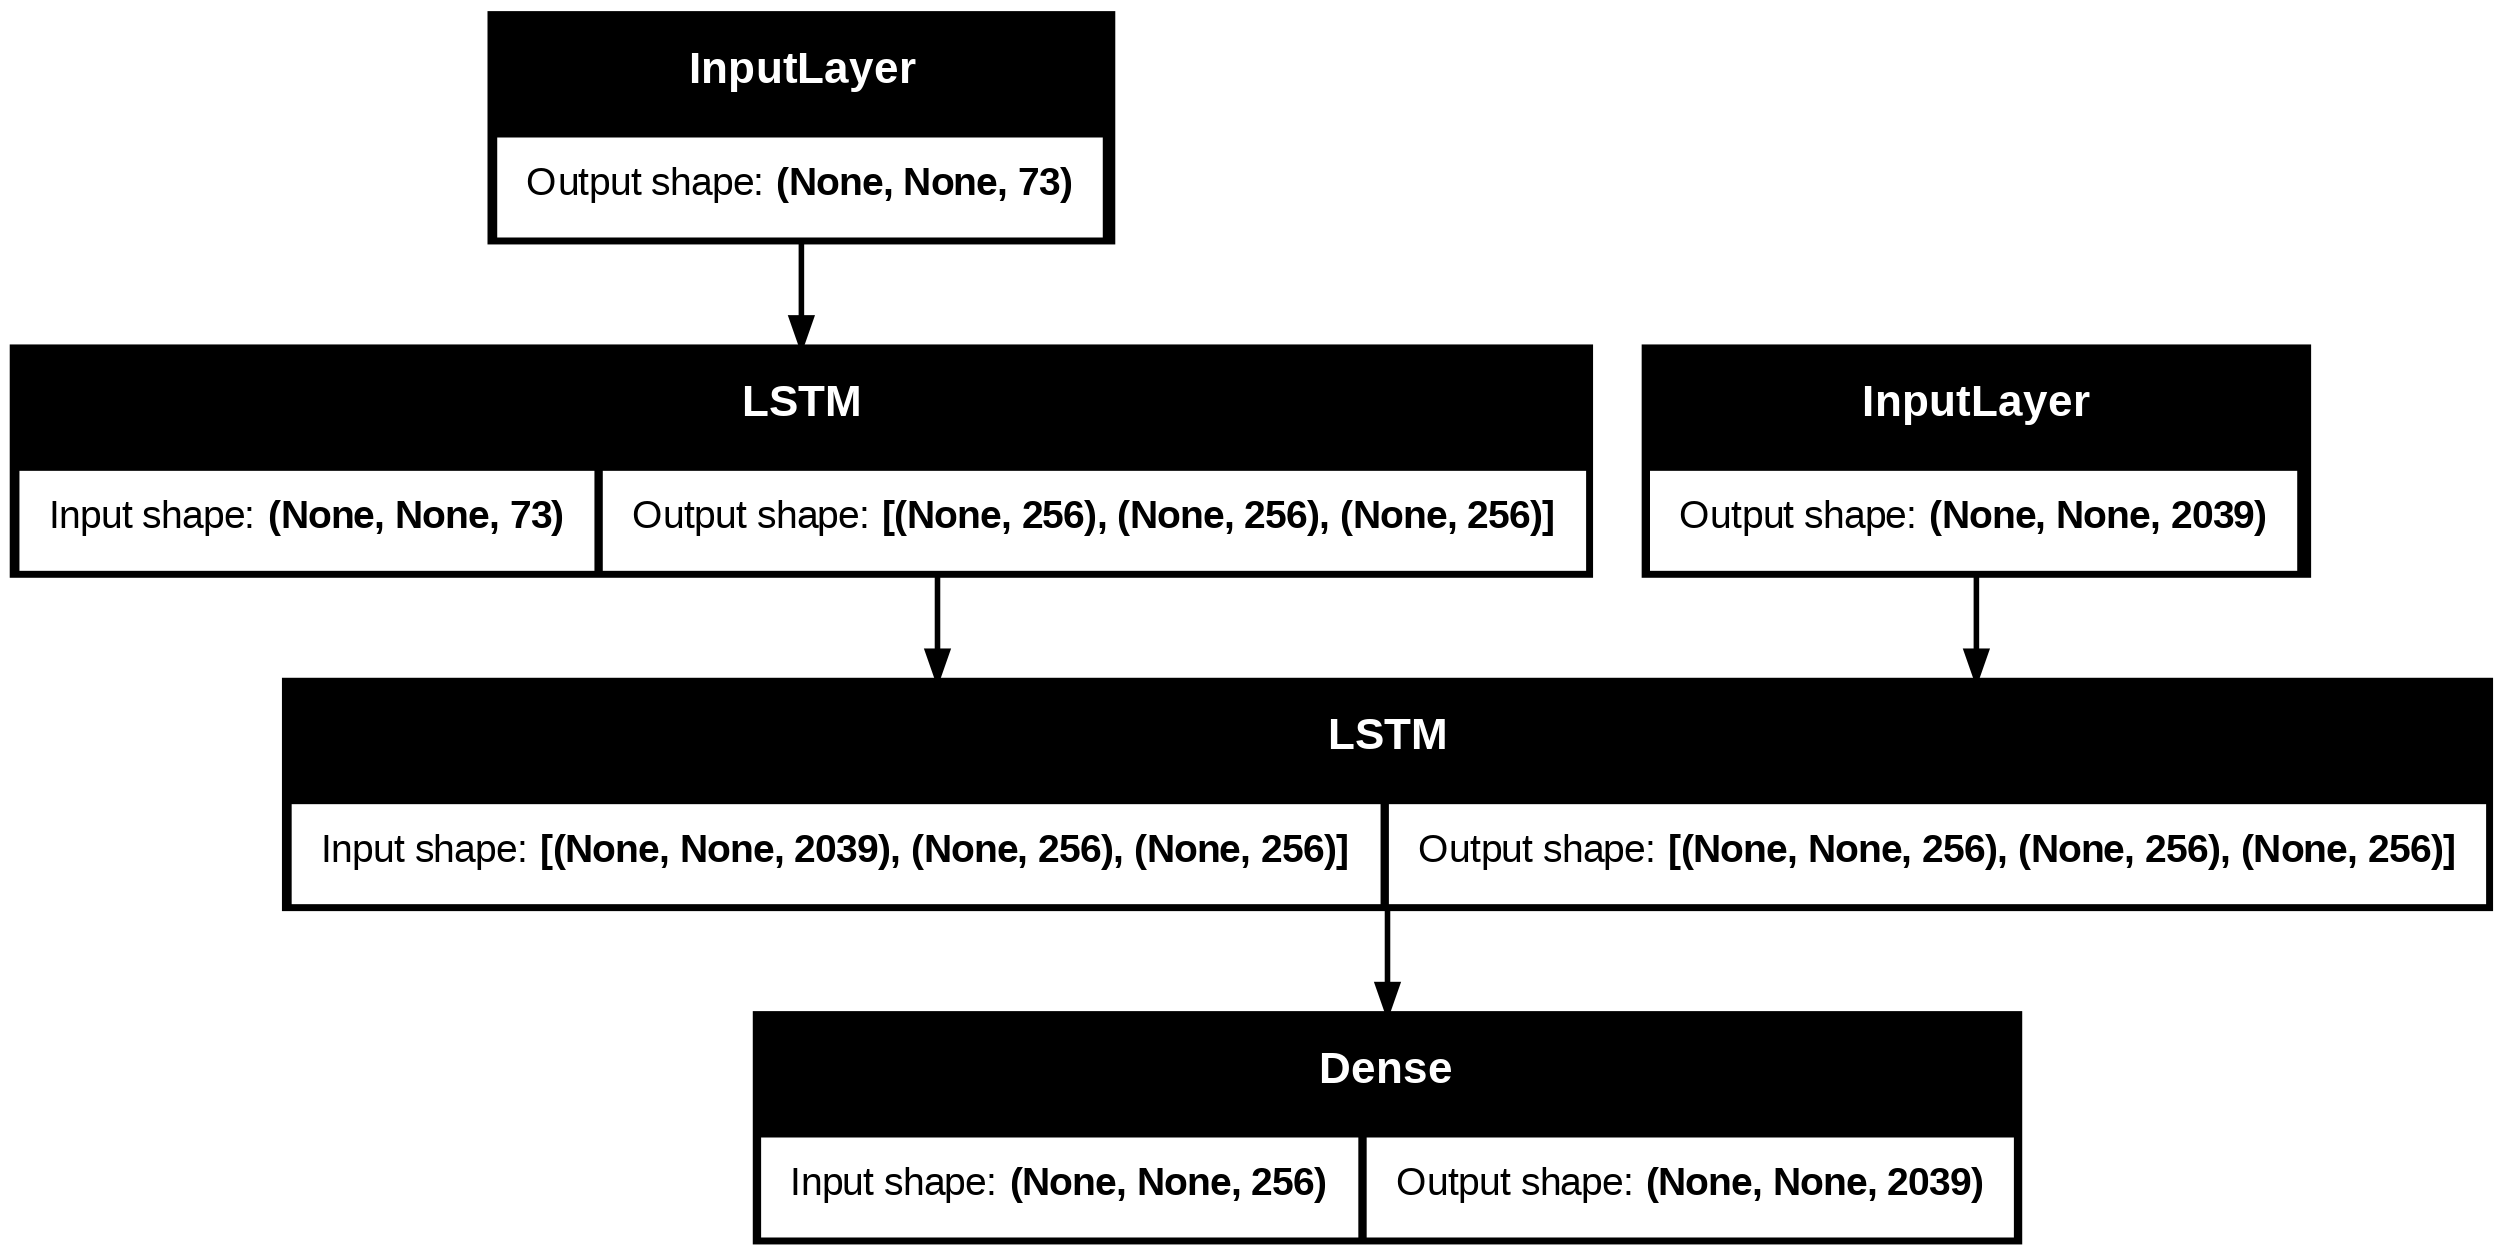

In [ ]:
# 繪製模型
# show_shapes=True：Layer 含 Input/Output 資訊
keras.utils.plot_model(model, "nmt1.png", show_shapes=True)

## 訓練模型

In [ ]:
# 訓練模型
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 908ms/step - accuracy: 0.6286 - loss: 3.1081 - val_accuracy: 0.6147 - val_loss: 2.2030
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 909ms/step - accuracy: 0.6771 - loss: 1.7921 - val_accuracy: 0.6296 - val_loss: 2.1570
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 854ms/step - accuracy: 0.6918 - loss: 1.7529 - val_accuracy: 0.6472 - val_loss: 2.1039
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 860ms/step - accuracy: 0.7232 - loss: 1.6619 - val_accuracy: 0.6704 - val_loss: 2.0250
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 845ms/step - accuracy: 0.7387 - loss: 1.5850 - val_accuracy: 0.6849 - val_loss: 1.9721
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 867ms/step - accuracy: 0.7427 - loss: 1.5557 - val_accuracy: 0.6868 - val_loss: 1.9498
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 842ms/step - accuracy: 0.7466 - loss: 1.5230 - val_accuracy: 0.6906 - val_loss: 1.9469
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 840ms/step - accuracy: 

In [ ]:
# 模型存檔
model.save("nmt2.keras")

NameError: name 'model' is not defined

## 預測
1. 對input編碼，取得解碼器的初起狀態
2. 執行解碼：將解碼器的初起狀態及原始輸入進行解碼
3. 重複執行，取得序列資料

In [ ]:
# # 載入模型，非必要
from os import path
if path.exists("nmt2.hkeras"):
    model = keras.models.load_model("nmt2")

## 設定字典，可將整數轉回文字

In [ ]:
# 取得 encoder 語意結構
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# 取得 decoder 的目標語言輸入
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# 設定字典，可將整數轉回文字
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

## 定義預測函數

In [ ]:
# 預測函數
def decode_sequence(input_seq):
    # 取得狀態(語意結構)
    states_value = encoder_model.predict(input_seq)

    # 初始化 decoder 目標語言輸出
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # 設定目標語言第一個字母為起始字母
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # 預測
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # 取得預測值
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 找到最大可能的字母
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 如果整句翻完，即結束
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # 輸出
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # 更新狀態
        states_value = [h, c]
    return decoded_sentence

## 測試前50筆

In [ ]:
encoder_input_data.shape

(10000, 25, 73)

In [ ]:
# 測試前50筆
for seq_index in range(50):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Input sentence: Hi.
Decoded sentence: 你好。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input sentence: Hi.
Decoded sentence: 你好。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input sentence: Run.
Decoded sentence: 你們的手。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34

## 自訂資料測試

In [ ]:
# 自訂資料測試
test_data = ['i love you', 'He told she he was tired', 'Run for your life!']
encoder_input_data = np.zeros(
    (len(test_data), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

for i, input_text in enumerate(test_data):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

for seq_index in range(encoder_input_data.shape[0]):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", test_data[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Input sentence: i love you
Decoded sentence: 我能用你的鋼在这儿吗？

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Input sentence: He told she he was tired
Decoded sentence: 他把他们的朋友。


In [ ]:
import googletrans

translator = googletrans.Translator()

In [ ]:
googletrans.LANGUAGES

{'af': 'afrikaans',
 'sq': 'albanian',
 'am': 'amharic',
 'ar': 'arabic',
 'hy': 'armenian',
 'az': 'azerbaijani',
 'eu': 'basque',
 'be': 'belarusian',
 'bn': 'bengali',
 'bs': 'bosnian',
 'bg': 'bulgarian',
 'ca': 'catalan',
 'ceb': 'cebuano',
 'ny': 'chichewa',
 'zh-cn': 'chinese (simplified)',
 'zh-tw': 'chinese (traditional)',
 'co': 'corsican',
 'hr': 'croatian',
 'cs': 'czech',
 'da': 'danish',
 'nl': 'dutch',
 'en': 'english',
 'eo': 'esperanto',
 'et': 'estonian',
 'tl': 'filipino',
 'fi': 'finnish',
 'fr': 'french',
 'fy': 'frisian',
 'gl': 'galician',
 'ka': 'georgian',
 'de': 'german',
 'el': 'greek',
 'gu': 'gujarati',
 'ht': 'haitian creole',
 'ha': 'hausa',
 'haw': 'hawaiian',
 'iw': 'hebrew',
 'he': 'hebrew',
 'hi': 'hindi',
 'hmn': 'hmong',
 'hu': 'hungarian',
 'is': 'icelandic',
 'ig': 'igbo',
 'id': 'indonesian',
 'ga': 'irish',
 'it': 'italian',
 'ja': 'japanese',
 'jw': 'javanese',
 'kn': 'kannada',
 'kk': 'kazakh',
 'km': 'khmer',
 'ko': 'korean',
 'ku': 'kurdish 

In [ ]:
results = translator.translate('Join us', src='en', dest='fr')
print(results.text)

Rejoignez-nous
